In [1]:
import os
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import argparse

In [ ]:
# os.makedirs('/content/drive/MyDrive/Trained Models')

In [2]:
directory = '/content/drive/MyDrive/Train/Train'
noisy_dir = os.path.join(directory, 'low')
clean_dir = os.path.join(directory, 'high')

In [3]:
all_file_names=os.listdir(noisy_dir)

In [4]:
len(all_file_names)

1940

In [5]:
all_file_names.sort()

In [6]:
all_file_names

['10.png',
 '100.png',
 '100lr.png',
 '100rot.png',
 '100ud.png',
 '101.png',
 '101lr.png',
 '101rot.png',
 '101ud.png',
 '102.png',
 '102lr.png',
 '102rot.png',
 '102ud.png',
 '103.png',
 '103lr.png',
 '103rot.png',
 '103ud.png',
 '104.png',
 '104lr.png',
 '104rot.png',
 '104ud.png',
 '105.png',
 '105lr.png',
 '105rot.png',
 '105ud.png',
 '106.png',
 '106lr.png',
 '106rot.png',
 '106ud.png',
 '107.png',
 '107lr.png',
 '107rot.png',
 '107ud.png',
 '109.png',
 '109lr.png',
 '109rot.png',
 '109ud.png',
 '10lr.png',
 '10rot.png',
 '10ud.png',
 '110.png',
 '110lr.png',
 '110rot.png',
 '110ud.png',
 '112.png',
 '112lr.png',
 '112rot.png',
 '112ud.png',
 '113.png',
 '113lr.png',
 '113rot.png',
 '113ud.png',
 '114.png',
 '114lr.png',
 '114rot.png',
 '114ud.png',
 '115.png',
 '115lr.png',
 '115rot.png',
 '115ud.png',
 '116.png',
 '116lr.png',
 '116rot.png',
 '116ud.png',
 '117.png',
 '117lr.png',
 '117rot.png',
 '117ud.png',
 '118.png',
 '118lr.png',
 '118rot.png',
 '118ud.png',
 '119.png',
 '

In [7]:
import random
random.seed(42)
train_filenames, test_filenames = train_test_split(all_file_names, test_size=0.05, random_state=42)

In [8]:
len(train_filenames)

1843

Custom Data Generator

In [9]:
def load_data(filenames, batch_size, noisy_dir, clean_dir, target_size=(256, 256)):
    while True:
        noisy_images = []
        clean_images = []
        np.random.shuffle(filenames)
        batch_filenames = np.random.choice(filenames, batch_size)
        for filename in batch_filenames:
            noisy_path = os.path.join(noisy_dir, filename)
            clean_path = os.path.join(clean_dir, filename)
            try:
                # Loading the images in target size
                noisy_image = load_img(noisy_path, target_size=target_size)
                clean_image = load_img(clean_path, target_size=target_size)

                # Converting to array
                noisy_array = img_to_array(noisy_image)
                clean_array = img_to_array(clean_image)

                noisy_array = noisy_array / 255.0
                clean_array = clean_array / 255.0

                noisy_images.append(noisy_array)
                clean_images.append(clean_array)
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
                continue

        yield np.array(noisy_images), np.array(clean_images)

In [10]:
#Creating the Generator for Training
train_generator = load_data(train_filenames,noisy_dir=noisy_dir,clean_dir=clean_dir,batch_size=24)
validation_generator = load_data(test_filenames,noisy_dir=noisy_dir,clean_dir=clean_dir,batch_size=24)

In [11]:
noisy_batch, clean_batch = next(train_generator)
print("Noisy batch shape:", noisy_batch.shape)
print("Clean batch shape:", clean_batch.shape)

Noisy batch shape: (24, 256, 256, 3)
Clean batch shape: (24, 256, 256, 3)


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model,load_model,model_from_json
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,BatchNormalization, Activation, ReLU, Flatten, Dense, Input
from tensorflow.keras.layers import Add, Multiply, Concatenate, Softmax,Reshape,Dropout
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.applications import VGG19
from tensorflow.image import ssim
tf.keras.backend.set_image_data_format('channels_last')
import keras.backend as K

#Creating The Convolutional Block Class

In [13]:
@tf.keras.saving.register_keras_serializable()
class Conv_block(tf.keras.layers.Layer):
    def  __init__(self, num_filters=200, kernel_size=3,**kwargs):
        super().__init__(**kwargs)
        self.num_filters=num_filters
        self.kernel_size=kernel_size
        self.conv_1 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_2 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_3 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_4 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.SE     = SEBlock(filters=self.num_filters)
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_filters': self.num_filters,
            'kernel_size':self.kernel_size
        })
        return config

    def call(self, X):
        X = self.conv_1(X)
        X = ReLU()(X)

        X = self.conv_2(X)
        X = ReLU()(X)

        X = self.conv_3(X)
        X = ReLU()(X)

        X = self.SE(X)
        return X

In [14]:
@tf.keras.saving.register_keras_serializable()
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, filters, reduction=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.filters = filters
        self.reduction = reduction
        self.global_avg_pool = GlobalAveragePooling2D()
        self.reshape = Reshape((1, 1, filters))
        self.dense1 = Dense(filters // reduction, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense2 = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)

    def call(self, input_tensor):
        se = self.global_avg_pool(input_tensor)
        se = self.reshape(se)
        se = self.dense1(se)
        se = self.dense2(se)
        return Multiply()([input_tensor, se])

    def get_config(self):
        config = super(SEBlock, self).get_config()
        config.update({
            'filters': self.filters,
            'reduction': self.reduction
        })
        return config

#Function for Wavelet Transformation

In [15]:
@tf.keras.saving.register_keras_serializable()
class DWT_downsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        x1 = x[:, 0::2, 0::2, :] #x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :] #x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :] #x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :] #x(2i, 2j)

        x_LL = x1 + x2 + x3 + x4
        x_LH = -x1 - x3 + x2 + x4
        x_HL = -x1 + x3 - x2 + x4
        x_HH = x1 - x3 - x2 + x4

        return Concatenate(axis=-1)([x_LL, x_LH, x_HL, x_HH])

      
        The following calculations for IWT and DWT are used from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        

In [16]:
@tf.keras.saving.register_keras_serializable()
class IWT_upsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4

        y1 = K.stack([x1,x3], axis=2)
        y2 = K.stack([x2,x4], axis=2)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1,y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))

# Defining Model Architecture

In [16]:
def create_model():
    tf.keras.backend.clear_session()

    input = Input(shape=(256,256,3))

    cb_1 = Conv_block(num_filters=64)(input)
    dwt_1 = DWT_downsampling()(cb_1)

    cb_2 = Conv_block(num_filters=128)(dwt_1)
    dwt_2 = DWT_downsampling()(cb_2)

    cb_3 = Conv_block(num_filters=256)(dwt_2)
    dwt_3 = DWT_downsampling()(cb_3)

    cb_4 = Conv_block(num_filters=512)(dwt_3)
    dwt_4 = DWT_downsampling()(cb_4)

    cb_5 = Conv_block(num_filters=512)(dwt_4)
    cb_5 = BatchNormalization()(cb_5)
    cb_5 = Conv_block(num_filters=512)(cb_5)
    cb_5 = Conv2D(filters=2048, kernel_size=3, strides=1, padding='same')(cb_5)

    up = IWT_upsampling()(cb_5)
    up = Conv_block(num_filters=512)(Add()([up, cb_4]))
    up = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=256)(Add()([up, cb_3]))
    up = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=128)(Add()([up, cb_2]))
    up = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=64)(Add()([up, cb_1]))
    up = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(up)

    out = Conv2D(filters=3, kernel_size=(1, 1), padding="same")(up)
    model=Model(inputs=[input],outputs=[out])
    return model

In [17]:
# Creating the model

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv_block (Conv_block)     (None, 256, 256, 64)         76160     ['input_1[0][0]']             
                                                                                                  
 dwt_downsampling (DWT_down  (None, 128, 128, 256)        0         ['conv_block[0][0]']          
 sampling)                                                                                        
                                                                                                  
 conv_block_1 (Conv_block)   (None, 128, 128, 128)        592256    ['dwt_downsampling[0][0]']

#Defining Callbacks

In [ ]:
best_models_path = "/content/drive/MyDrive/Trained_Model"
callbacks_lst = [
    tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"Final_MWCNN_Checkpoint.h5",
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True,
                                        save_freq='epoch',
                                        verbose=1
                                       ),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.67, patience=2, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=8)
]

In [18]:
steps_per_epoch=np.ceil(len(train_filenames)/24)
steps_per_validation=np.ceil(len(test_filenames)/24)
print(steps_per_epoch,steps_per_validation)

77.0 5.0


#Creating Custom Loss Function

In [17]:
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256,256,3))
vgg.trainable = False
def perceptual_loss(y_true, y_pred):
    true_features=vgg(y_true)
    pred_features=vgg(y_pred)
    return MeanSquaredError()(true_features, pred_features)

80134624/80134624 [==============================] - 0s 0us/step


In [18]:
def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [19]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))

In [20]:
def net_loss(y_pred,y_true):
  perceptual=perceptual_loss(y_true=y_true,y_pred=y_pred)
  ssim=ssim_loss(y_true=y_true,y_pred=y_pred)
  return ssim + perceptual

In [ ]:
model.compile(loss=['mae',net_loss],loss_weights=[10,1],optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-8),metrics=[psnr,'mse','mae'])

#Training The Model

First Training with loss weightage 10:1 (MAE:Net_Loss)

In [ ]:
history=model.fit(
          train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=30,
          verbose=1,
          validation_data=validation_generator,
          validation_steps=steps_per_validation,
          callbacks=callbacks_lst
)

Epoch 1/30
77/77 [==============================] - ETA: 0s - loss: 2.6407 - psnr: 11.7032 - mse: 0.1597 - mae: 0.2641
Epoch 1: val_loss improved from inf to 1.57112, saving model to /content/drive/MyDrive/Trained_ModelFinal_MWCNN_Checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 485s 5s/step - loss: 2.6407 - psnr: 11.7032 - mse: 0.1597 - mae: 0.2641 - val_loss: 1.5711 - val_psnr: 15.4569 - val_mse: 0.0368 - val_mae: 0.1571 - lr: 0.0010
Epoch 2/30
77/77 [==============================] - ETA: 0s - loss: 1.3910 - psnr: 16.3834 - mse: 0.0300 - mae: 0.1391
Epoch 2: val_loss improved from 1.57112 to 1.30671, saving model to /content/drive/MyDrive/Trained_ModelFinal_MWCNN_Checkpoint.h5
77/77 [==============================] - 211s 3s/step - loss: 1.3910 - psnr: 16.3834 - mse: 0.0300 - mae: 0.1391 - val_loss: 1.3067 - val_psnr: 16.8955 - val_mse: 0.0248 - val_mae: 0.1307 - lr: 0.0010
Epoch 3/30
77/77 [==============================] - ETA: 0s - loss: 1.1903 - psnr: 17.4920 - mse: 0.0227 - mae: 0.1190
Epoch 3: val_loss improved from 1.30671 to 1.07127, saving model to /content/drive/MyDrive/Trained_ModelFinal_MWCNN_Checkpoint.h5
77/77 [==============================] - 184s 2s/step - loss: 1.1903 - psnr: 17.4920 - mse: 0.0227 -

Second Training with loss weightage 10:1 (MAE:Net_Loss)

In [ ]:
history=model.fit(
          train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=20,
          verbose=1,
          validation_data=validation_generator,
          validation_steps=steps_per_validation,
          callbacks=callbacks_lst
)

Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 0.7801 - psnr: 21.2390 - mse: 0.0100 - mae: 0.0780
Epoch 1: val_loss improved from 0.81381 to 0.73276, saving model to /content/drive/MyDrive/Trained_ModelFinal_MWCNN_Checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 210s 2s/step - loss: 0.7801 - psnr: 21.2390 - mse: 0.0100 - mae: 0.0780 - val_loss: 0.7328 - val_psnr: 21.8005 - val_mse: 0.0089 - val_mae: 0.0733 - lr: 1.0000e-04
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 0.7794 - psnr: 21.2934 - mse: 0.0100 - mae: 0.0779
Epoch 2: val_loss did not improve from 0.73276
77/77 [==============================] - 173s 2s/step - loss: 0.7794 - psnr: 21.2934 - mse: 0.0100 - mae: 0.0779 - val_loss: 0.8117 - val_psnr: 20.9586 - val_mse: 0.0105 - val_mae: 0.0812 - lr: 1.0000e-04
Epoch 3/20
77/77 [==============================] - ETA: 0s - loss: 0.7613 - psnr: 21.4748 - mse: 0.0099 - mae: 0.0761
Epoch 3: val_loss did not improve from 0.73276

Epoch 3: ReduceLROnPlateau reducing learning rate to 6.699999830743764e-05.
77/77 [==============================] - 172s 2s/step - loss: 0.7613 - psnr: 21.4748 - mse: 0.0099 - mae: 0.0761 - val_loss: 0.7999 - val_psnr: 21.2163 - val_mse: 0.0108 - val_mae: 

In [ ]:
tf.keras.models.save_model(model,'/content/drive/MyDrive/MWCNN_Final_1.h5')

<ipython-input-62-d0d035b4f257>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'/content/drive/MyDrive/MWCNN_Final_1.h5')


In [26]:
best_models_path = "/content/drive/MyDrive/Trained_Model"
callbacks_lst = [
    tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"Final_MWCNN_Checkpoint_2.h5",
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True,
                                        save_freq='epoch',
                                        verbose=1
                                       ),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.67, patience=2, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=8)
]

In [29]:
model.compile(loss=['mae',net_loss],loss_weights=[1,10],optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-8),metrics=[psnr,'mse','mae'])

In [24]:
custom_objects={'Conv_block':Conv_block,'SEBlock':SEBlock,'IWT_upsampling':IWT_upsampling,'DWT_downsampling':DWT_downsampling,'psnr':psnr,'perceptual_loss':perceptual_loss,'net_loss':net_loss,'ssim_loss':ssim_loss}

In [25]:
model=load_model('/content/drive/MyDrive/MWCNN_Final_1.h5',custom_objects=custom_objects)

Third Training with loss weightage 1:10 (MAE:Net_Loss)

In [30]:
history=model.fit(
          train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=20,
          verbose=1,
          validation_data=validation_generator,
          validation_steps=steps_per_validation,
          callbacks=callbacks_lst
)

Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 0.0745 - psnr: 21.6555 - mse: 0.0094 - mae: 0.0745
Epoch 1: val_loss improved from inf to 0.07709, saving model to /content/drive/MyDrive/Trained_ModelFinal_MWCNN_Checkpoint_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 634s 8s/step - loss: 0.0745 - psnr: 21.6555 - mse: 0.0094 - mae: 0.0745 - val_loss: 0.0771 - val_psnr: 21.5949 - val_mse: 0.0099 - val_mae: 0.0771 - lr: 1.0000e-04
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 0.0739 - psnr: 21.7334 - mse: 0.0092 - mae: 0.0739
Epoch 2: val_loss did not improve from 0.07709
77/77 [==============================] - 253s 3s/step - loss: 0.0739 - psnr: 21.7334 - mse: 0.0092 - mae: 0.0739 - val_loss: 0.0890 - val_psnr: 20.2213 - val_mse: 0.0134 - val_mae: 0.0890 - lr: 1.0000e-04
Epoch 3/20
77/77 [==============================] - ETA: 0s - loss: 0.0729 - psnr: 21.8229 - mse: 0.0089 - mae: 0.0729
Epoch 3: val_loss improved from 0.07709 to 0.07457, saving model to /content/drive/MyDrive/Trained_ModelFinal_MWCNN_Checkpoint_2.h5
77/77 [==============================] - 199s 3s/step - loss: 0.0729 - psnr: 21.8229 - mse: 0.0089 - mae: 0.0729 - val_loss: 0.0746 - val_psnr: 21.8007 - val_mse: 0.0093 - v

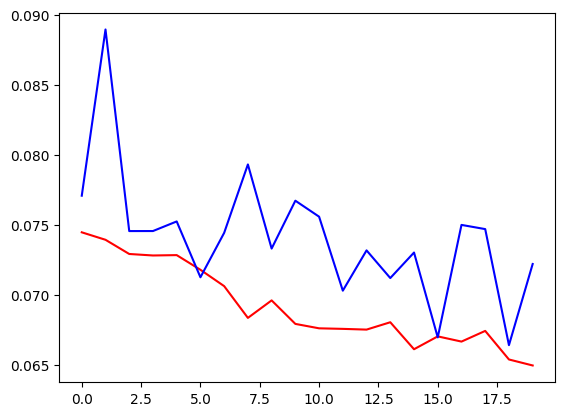

In [31]:
plt.plot(history.history['loss'],c='r')
plt.plot(history.history['val_loss'],c='b')

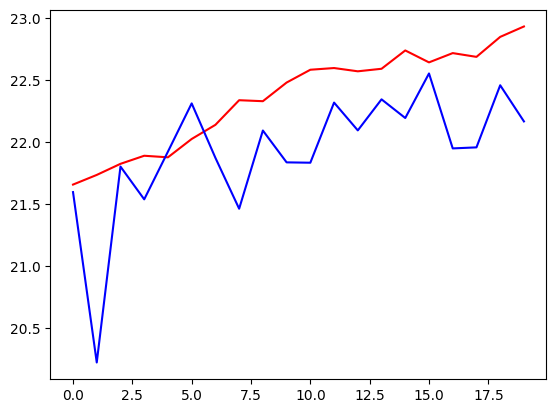

In [32]:
plt.plot(history.history['psnr'],c='r')
plt.plot(history.history['val_psnr'],c='b')

In [21]:
custom_objects={'Conv_block':Conv_block,'SEBlock':SEBlock,'IWT_upsampling':IWT_upsampling,'DWT_downsampling':DWT_downsampling,'psnr':psnr,'perceptual_loss':perceptual_loss,'net_loss':net_loss,'ssim_loss':ssim_loss}

In [22]:
model=load_model('/content/drive/MyDrive/Trained_ModelFinal_MWCNN_Checkpoint_2.h5',custom_objects=custom_objects)

In [24]:
#Test and Validation are same
result=model.evaluate(validation_generator,steps=5)

5/5 [==============================] - 510s 97s/step - loss: 0.0761 - psnr: 21.6436 - mse: 0.0097 - mae: 0.0761


In [25]:
noisy_test,clean_test=next(validation_generator)

In [26]:
output_img=model.predict(noisy_test)

1/1 [==============================] - 83s 83s/step


In [36]:
import time

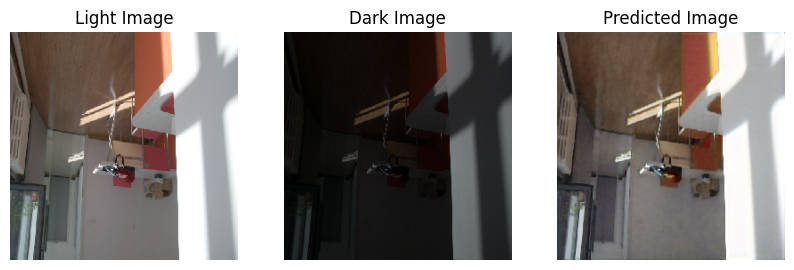

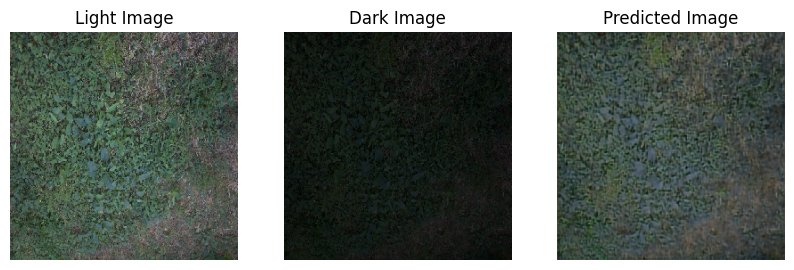

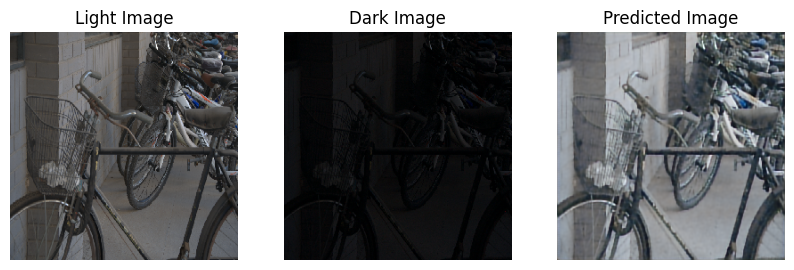

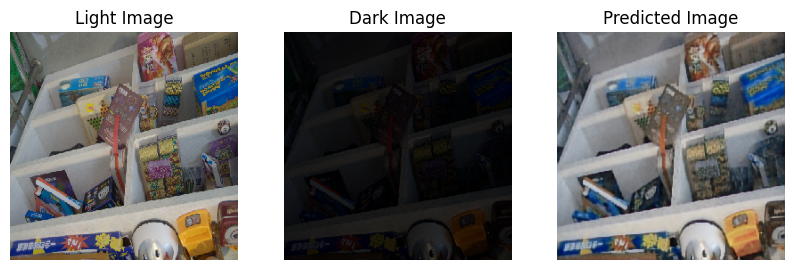

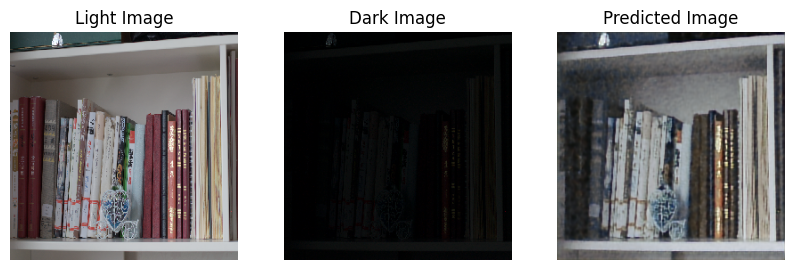

In [39]:
for i in range(5):
  fig,axes=plt.subplots(1,3,figsize=(10,10))
  axes[0].imshow(clean_test[i])
  axes[0].set_title('Light Image')
  axes[0].axis('off')
  axes[1].imshow(noisy_test[i])
  axes[1].set_title('Dark Image')
  axes[1].axis('off')
  axes[2].imshow(output_img[i])
  axes[2].set_title('Predicted Image')
  axes[2].axis('off')

In [40]:
model_json=model.to_json()

In [41]:
model_weights=model.get_weights()

In [42]:
import joblib

In [43]:
config={
    'model_json':model_json,
    'model_weights':model_weights
}

In [44]:
joblib.dump(config,'/content/drive/MyDrive/FINAL_MODEL.joblib',compress=True)

['/content/drive/MyDrive/FINAL_MODEL.joblib']